**Problem set 2: Olalla Nieto Faza**


In [1]:
# Import libraries
import qiskit
from qiskit.quantum_info import SparsePauliOp , Pauli
from qiskit.quantum_info import PauliList , Operator

import pandas as pd
import itertools
import numpy as np
from numpy import linalg as LA

from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
from qiskit.circuit import ParameterVector
from qiskit.compiler import transpile
from qiskit.visualization import plot_histogram

import matplotlib.pyplot as plt

import sys
print(sys.version)

import qiskit_aer

print(qiskit.__version__)
print(qiskit_aer.__version__)

from qiskit_aer import AerSimulator

3.12.7 | packaged by Anaconda, Inc. | (main, Oct  4 2024, 13:17:27) [MSC v.1929 64 bit (AMD64)]
2.0.3
0.17.0


*3.1:  Implement a simulation of the Three-Qubit Heisenberg Model using the second-order Trotterization method.*

$$
    \hat{U}(\Delta t) \approx e^{-\frac{i}{2} \hat{H}_1 \Delta t}\cdots e^{-\frac{i}{2} \hat{H}_L \Delta t}e^{-\frac{i}{2} \hat{H}_L \Delta t}\cdots e^{-\frac{i}{2} \hat{H}_1 \Delta t}.
$$

*Verify whether this approach requires fewer time steps $n_t$ (or, equivalently, a larger \Delta t) to reach the same level of accuracy as the first order method.*

***Direct exponentiation*** Taken from class materials


In [2]:
X = np.array([[0, 1.0], [1.0, 0]])
Y = np.array([[0, -1.0j], [1.0j, 0]])
Z = np.array([[1.0, 0.0], [0.0, -1.0]])
I = np.identity(2)

# Definition of the Hamiltonian
#-------------------------------------------
def H3(B):
    X = np.array([[0, 1.0], [1.0, 0]])
    Y = np.array([[0, -1.0j], [1.0j, 0]])
    Z = np.array([[1.0, 0.0], [0.0, -1.0]])
    I = np.identity(2)
    H2 = np.kron(X, X) + np.kron(Y, Y) + np.kron(Z, Z)   
    H0 = np.kron(I, H2) + np.kron(H2, I)
    Hg = np.kron(np.kron(Z, I), I) + np.kron(np.kron(I, Z), I) + np.kron(np.kron(I, I), Z)
    # Hg is the magnetic field term, interaction of Z2+Z1+Z0 with external field B
    return H0 + 0.5*B*Hg

# Building initial state, returns the computational basis vector |q2q1q0>
#-------------------------------
def psi0(q2, q1, q0):
    """
    qi in binary
    """
    comp_basis = np.array([[1.0,0],[0, 1.0]])
    return np.kron(comp_basis[:, q2], np.kron(comp_basis[:, q1], comp_basis[:, q0]))

from scipy.linalg import expm

# Unitary evolution: Uses the matrix exponential to compute U(t)=e^{-iHt}
#------------------------------------------------------------------------
def U3(t, B):
    return expm(-1.0j*t*H3(B))


# Time evolution
#-------------------------------------
#ts = np.linspace(0, np.pi, 100)   # 100 t_i from 0 to \pi
ts = np.linspace(0, np.pi, 200)   # 100 t_i from 0 to \pi
B=20

ut = [U3(t, B) for t in ts]      # For each t in the ts list, computes U(t) with field B=20

p0 = psi0(1, 1, 0)    # Defines p0 as the initial state |100>

pts = [u@p0 for u in ut]   # For each point in the ut list (U(t), calculates psi(t)

p0pts = np.array([p0@pt for pt in pts])    # computes the overlap between <psi(0)|psi(t)>
        # its square gives the probability of returning to the initial state over time.



# Define magnetization operator
Mz = np.kron(np.kron(Z, I), I) + np.kron(np.kron(I, Z), I) + np.kron(np.kron(I, I), Z)
# Compute magnetization values
mz_vals = [np.real(pt.conj().T @ Mz @ pt) for pt in pts]
# I found the same error in plotting as in Exercise 3, I don't have time to try and debug the plot



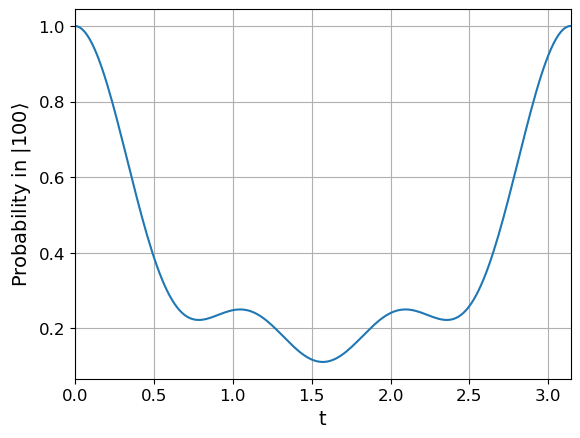

In [3]:
plt.plot(ts, np.abs(p0pts)**2)    # plot the survival probability in the state |100>
#plt.plot(ts, mz_vals)    # plot the survival probability in the state |100>
plt.xlim([0, np.pi])
plt.grid()
plt.xlabel("t", fontsize=14)
plt.ylabel(r"Probability in $|100\rangle$", fontsize=14)

plt.tick_params(axis='both', which='major', labelsize=12)



***Circuit implementation***  

For the first order Trotterization we divide the Hamiltonian in the following two-qubit terms:

$$
H=H_0+H_B=H=(H_{01}+H_{12})+\frac{B}{2}\left(Z_0+Z_1+Z_2  \right)
$$

The first-order Trotter approximation:

$$
e^{-iH\delta t}\approx e^{-iH_0\delta t}e^{-iH_B\delta t}=e^{-iH_{01}\delta t}e^{-iH_{12}\delta t}e^{-iH_B\delta t}
$$

And the Trotter step:

$$
U(t) \approx \left( e^{-i\delta t (H_{01}+H_{12})}e^{-i\delta t \frac{B}{2}(Z_0+Z_1+Z_2)}  \right)^n
$$

In [4]:
# We start by defining the two-qubit Heisenberg evolution (terms XX + YY + ZZ)
#--------------------------------------------------------------------------------
def heisenberg_ev(qc,q0,q1,dt):
    # XX + YY + ZZ via basis change and RZZ as in Problem 1. 
    # Equivalent with the other terms
    # ZZ
    qc.cx(q1, q0)
    qc.rz(2 * dt, q0)
    qc.cx(q1, q0)
    # YY
    qc.sdg(q0)
    qc.h(q0)
    qc.sdg(q1)
    qc.h(q1)
    qc.cx(q1, q0)
    qc.rz(2 * dt, q0)
    qc.cx(q1, q0)
    qc.h(q0)
    qc.s(q0)
    qc.h(q1)
    qc.s(q1)
    # XX
    qc.h(q0)
    qc.h(q1)
    qc.cx(q1, q0)
    qc.rz(2 * dt, q0)
    qc.cx(q1, q0)
    qc.h(q0)
    qc.h(q1)

    return qc

# Evolution of the Z-field (terms X + Y + Z) e^{-i\theta Z} =R_z(2\theta)
#--------------------------------------------------------------------------------
def zfield_ev(qc, B, dt, qubits):
    theta = B/2 * dt  # Because 0.5*B*(Z0 + Z1 + Z2)
    for q in qubits:
        qc.rz(theta, q)
    return qc

# Build full Trotter step
#----------------------------------------------------------------------------
def trotter_step1(B, dt):
    qc = QuantumCircuit(3, 3, name="TrotterStep_1")
    # Apply Heisenberg on (q0, q1) and (q1, q2)
    heisenberg_ev(qc, 0, 1, dt)
    heisenberg_ev(qc, 1, 2, dt)

    
    # Apply magnetic field on all three qubits
    zfield_ev(qc, B , dt, [0, 1, 2])

    return qc



# Repeat n Trotter steps to simulate U(t)
#----------------------------------------------
def build_trotter_circuit(B, t, n):
    dt = t / n
    qc = QuantumCircuit(3,3)
    
    # Prepare initial state |001>
    #----------------------------------------------
    qc.x(0)  # Qubit 2 to |1>, others |0>
    #----------------------------------------------

    # Apply n Trotter steps
    #-------------------------
    for _ in range(n):
        step=trotter_step1(B,dt)
        qc.compose(step, inplace=True)

    # Add measurement
    qc.measure(range(3), range(3))
   
    return qc

# Run simulation
#---------------------------------------------
def simulate(B, t, n, shots):
    backend = AerSimulator()
    qc = build_trotter_circuit(B, t, n)
    job = backend.run(qc, shots=shots)
    result = job.result()
    return result


# We start the program
#-----------------------------------------
#-----------------------------------------
t = np.pi   # we choose t=pi and B=20 to compare with the analytical solution
n = 75       # number of Trotter steps
B = 20     # magnetic field 
#-----------------------------------------
#-----------------------------------------
circuit = build_trotter_circuit(B, t, n)
circuit.draw("mpl")
shots=10000
result = simulate(B, t, n, shots)

counts = result.get_counts()
# Probability to remain in |001>
#---------------------------------------
p_initial = counts.get('001', 0) / shots

print(f"Probability to stay in |001>: {p_initial:.4f}")


Probability to stay in |001>: 1.0000


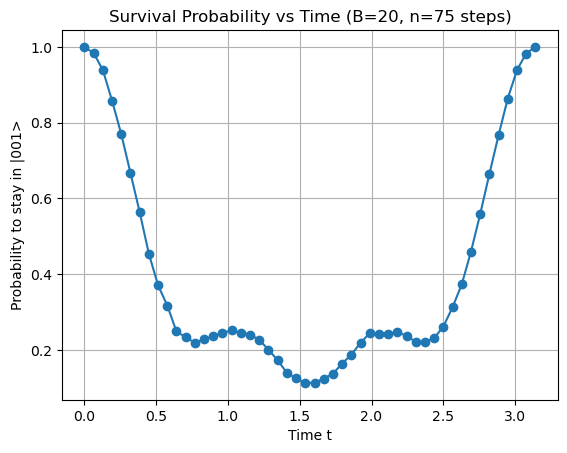

In [5]:
times = np.linspace(0, np.pi, 50)  # 50 time points to evaluate
prob_stay = []

backend = AerSimulator()

for t in times:
    result = simulate(B, t, n, shots)
    counts = result.get_counts()
    p = counts.get('001', 0) / shots
    prob_stay.append(p)

plt.plot(times, prob_stay, marker='o')
plt.xlabel('Time t')
plt.ylabel('Probability to stay in |001>')
plt.title(f'Survival Probability vs Time (B={B}, n={n} steps)')
plt.grid(True)
plt.show()

Now we work on the second-order Trotterization with the following formula for the time evolution:
 $$ \hat{U}(\Delta t) \approx e^{-\frac{i}{2} \hat{H}_1 \Delta t}\cdots e^{-\frac{i}{2} \hat{H}_L \Delta t}e^{-\frac{i}{2} \hat{H}_L \Delta t}\cdots e^{-\frac{i}{2} \hat{H}_1 \Delta t}$$

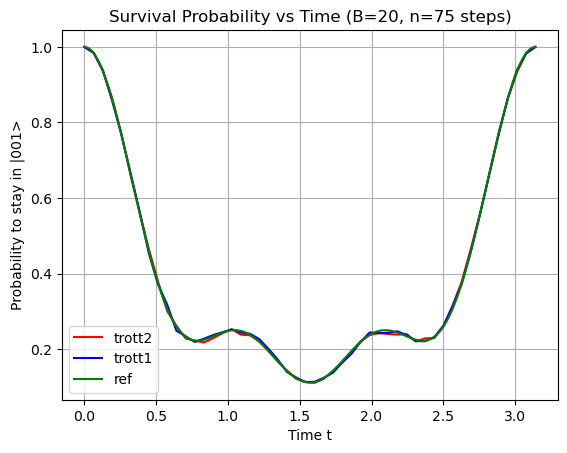

In [7]:
# We prepare a new trotter step applying half of the magnetic field evolution (all qubits)
# then half of the Heisenberg evolution on qubits 0 and 1, the whole Heisenberg evolution on
# qubits 1 and 2 and the other half Heisenberg evolution on qubits 0 and 1 and the magnetic
# field evolution  (all qubits)
#------------------------------------------------------------------------------
def trotter_step2(B, dt):
    
    qc = QuantumCircuit(3, name="TrotterStep_2")
    
    # Half Z-field
    zfield_ev(qc, B, dt/2, [0,1,2])
    
    # Half Heisenberg on (0,1)
    heisenberg_ev(qc, 0, 1, dt/2)
    
    # Full Heisenberg on (1,2)
    heisenberg_ev(qc, 1, 2, dt)
    
    # Half Heisenberg on (0,1)
    heisenberg_ev(qc, 0, 1, dt/2)
    
    # Half Z-field
    zfield_ev(qc, B, dt/2, [0,1,2])
    
    return qc

# Repeat n Trotter steps to simulate U(t)
#----------------------------------------------
def build_trotter_circuit2(B, t, n):
    dt = t / n
    qc2 = QuantumCircuit(3,3)
    
    # Prepare initial state |001>
    #----------------------------------------------
    qc2.x(0)  # Qubit 2 to |1>, others |0>
    #----------------------------------------------

    # Apply n Trotter steps
    #-------------------------
    for _ in range(n):
        step=trotter_step2(B,dt)
        qc2.compose(step, inplace=True)

    # Add measurement
    qc2.measure(range(3), range(3))
   
    return qc2

# Run simulation
#---------------------------------------------
def simulate2(B, t, n, shots):
    backend = AerSimulator()
    qc2 = build_trotter_circuit2(B, t, n)     # I change qc to qc2 here because I didn't make
    job = backend.run(qc2, shots=shots)       # sure that the circuits are well defined inside each
    result2 = job.result()                    # function and I'm not modifying a previous circuit
    return result2


# Run the program
#----------------------------------------------------------------
t = np.pi   # we choose t=pi and B=20 to compare with the analytical solution
n = 75       # number of Trotter steps
B = 20     # magnetic field 
#-----------------------------------------
#-----------------------------------------

times2 = np.linspace(0, np.pi, 50)  # 50 time points to evaluate
prob_stay2 = []

backend = AerSimulator()

for t in times:
    result2 = simulate2(B, t, n, shots)
    counts2 = result2.get_counts()
    p2 = counts2.get('001', 0) / shots
    prob_stay2.append(p2)

#plt.plot(times2, prob_stay2, marker='o',label='trott2',color='red')
plt.plot(times2, prob_stay2,label='trott2',color='red')
plt.plot(times,prob_stay,label='trott1',color='blue')
plt.plot(ts, np.abs(p0pts)**2,label='ref',color='green') 
plt.xlabel('Time t')
plt.ylabel('Probability to stay in |001>')
plt.title(f'Survival Probability vs Time (B={B}, n={n} steps)')
plt.grid(True)
plt.legend()
plt.show()

When the number of Trotter steps is $n=5$ the results are actually significantly worse for the second-order than for the first-order approximation. When $n$ increases up to $n=25$ or $n=30$, the second-order plot seems to better match the reference curve. At $n=50$ the results are almost indistinguishable. I should calculate an average error over the whole plot but when  zooming on a smaller region of the plot, second-order seems to be slightly worse than first-order. 